# Model tuning

### Hyperparamter tuning
Once the model is complete, it is worth to fine tune its hyperparameters with a few specific models available and tested here: 
1) grid-search, 
2) random search 
3) Bayesian optimisation.
- Hyparameters are values that guide the learning process whereas the values of other parameters are determined as an outcome.
- For Neural Network, the parameters are the weights and biases, hyperparameters are number of neuron per layers, number of layers, and the batch size.
- Hyperparameters in terms of random forest is the number of trees 
- Number of neighbors for K-nearest neighbor#

Ref for Tuning Random Forest with [Grid Search](https://www.blog.trainindata.com/random-forest-with-grid-search/)

In [1]:
import pandas as pd
import numpy as np#linear algebra
import pandas as pd#data processing
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Using the sonar dataset that contains 208 rows (samples) and 60 columns(inputs)
The model should be able to judge  if the sonar signal is bouncing off a metal object or a rock-like object (a classificaiton problem)

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
dataframe = pd.read_csv(url, header = None)

# split into input and output elements
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

(208, 60) (208,)


Setting up the grid search for hyperparameters to use in the search process

In [3]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators':[10, 50, 100, 150, 200],
    'max_depth':[None, 10, 20, 30, 40, 50],
    'max_features':['auto', 'sqrt', 'log2'],
    #'boostrap':[True, False]
}

- Initiatiliza the randomforest algorithm i.e. create an instance of the Random Forest algorithm to be trained.
- We will use `GridSearchCV` class in the scikit-learn lib that performs an exchaustive search over our specified parameter values.
- last we use fit to train the underlying rf model on the training data for each combination of hyperparameters (choosing the combination that gives the best performance based on our specified scoring method)

In [4]:
from sklearn.model_selection import GridSearchCV
# Initialize a random forest classifier
rf = RandomForestClassifier()

# Use grid search with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/hom

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='accuracy')

In [5]:
# Evaluate the best model from grid search on the test set
from sklearn.metrics import accuracy_score
y_pred_baseline =rf.fit(X_train, y_train).predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
y_pred_grid_search = grid_search.best_estimator_.predict(X_test)
grid_search_accuracy = accuracy_score(y_test, y_pred_grid_search)
improvement_grid_search = (grid_search_accuracy - baseline_accuracy) / baseline_accuracy * 100 
print("Baseline Accuracy:", baseline_accuracy)
print("Accuracy after Grid Search:", grid_search_accuracy)
print("Improvement in Accuracy using Grid Search:", improvement_grid_search)


Baseline Accuracy: 0.8269230769230769
Accuracy after Grid Search: 0.8653846153846154
Improvement in Accuracy using Grid Search: 4.6511627906976845


-  Need to plot some scatter plots to get more insights into what what's happening during the grid search operation.
-We will plot the accuracy against two hyperparameters to provide some helpful expectations when deciding the trade-off between computational cost and accuracy

In [14]:
# Extract mean test scores
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Extract values of the hyperparameters for all combinations
param_n_estimators = [param['n_estimators'] for param in grid_search.cv_results_['params']]
param_max_depth = [param['max_depth'] for param in grid_search.cv_results_['params']]

Text(0.5, 1.0, 'Accuracy vs Max Depth')

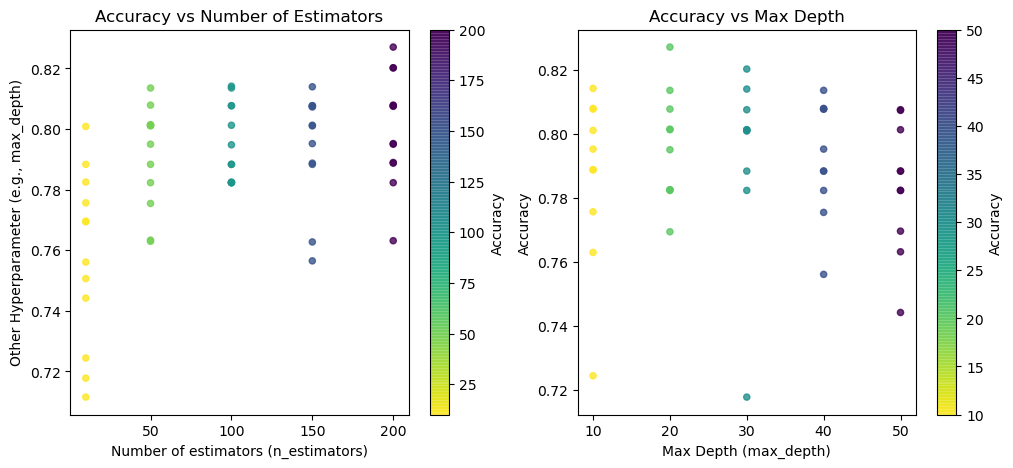

In [30]:
# Plot the contour
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

#Create the two scatter plots of number of estimators 
# and max depth
colors1 = len(param_n_estimators)
sc1 = ax1.scatter(param_n_estimators,mean_test_scores, 
                  c=param_n_estimators, 
                  cmap='viridis_r', s=20, alpha=0.8
                  )
fig.colorbar(sc1, ax=ax1, label='Accuracy')
    
ax1.set_xlabel('Number of estimators (n_estimators)')
ax1.set_ylabel('Other Hyperparameter (e.g., max_depth)')
ax1.set_title('Accuracy vs Number of Estimators')

colors2 = len(param_max_depth)
sc2 = ax2.scatter(param_max_depth,mean_test_scores, 
                  c=param_max_depth, 
                  cmap='viridis_r', s=20, alpha=0.8
                  )
fig.colorbar(sc2, ax=ax2, label='Accuracy')
ax2.set_xlabel('Max Depth (max_depth)')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Max Depth')


Observing the above plots of the accuracy against number of estimators and max depth, we get some more information about what is happening duing the grid search operation. But the problem still remains on which hyperparameters we should pick.

- Next we try the random search to try to define the hyperparameter ranges with random distributions and using the k-fold cross-validation (the dataset will be split into 5 parts/folds,whereby the data is rotated in the 4 training and 1 validation fold)
- n_iter assigns a number for allocated iterations to perform in the search; i.e. the number of combinations of hyperparameters to try.

In [37]:
from random import randint
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators' : [20,50,100,200],
    'max_depth': [None] + list(randint(10, 50) for _ in range(5)),
    'max_features' : ['auto', 'sqrt', 'log2'],
    #'bootstrap':[True, False]
}

# Initialize RandomizedSearchCV with a fixed number of iterations
random_search = RandomizedSearchCV(rf, param_distributions= param_dist, n_iter=100, cv=5,
                                   scoring='accuracy', random_state=42)

In [38]:
random_search.fit(X_train, y_train)

/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/conmec/miniconda3/lib/pyth

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [None, 20, 13, 41, 34, 47],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [20, 50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [39]:
# Obtain the best accuracy
best_accuracy = random_search.best_score_
print(f"Best Accuracy from Random Search:{best_accuracy:.4f}")
print(f"Improvement in Accuracy: {100 * (best_accuracy-baseline_accuracy):2f}%")

Best Accuracy from Random Search:0.8397
Improvement in Accuracy: 1.279467%


-  The result is that the best model accuracy is in the same ballpark as the grid-search.

90


Text(0.5, 1.0, 'Random Search Scores vs Baseline')

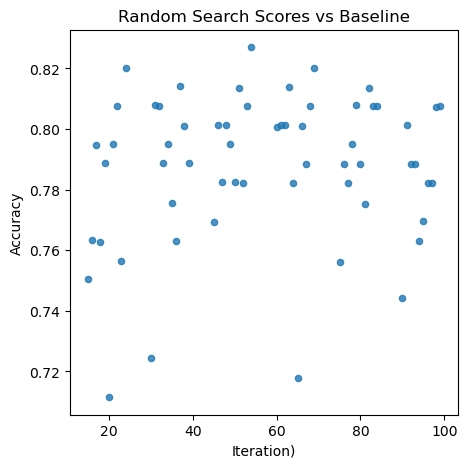

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

#Create the two scatter plots of number of estimators 
# and max depth
print(len(mean_test_scores))
ax.scatter(range(10,100), mean_test_scores, s=20, alpha=0.8)    
ax.set_xlabel('Iteration)')
ax.set_ylabel('Accuracy')
ax.set_title('Random Search Scores vs Baseline')


### Bayesian Optimization 

- Another way to determine the best hyperparameter is via optimization approach. 
- Here we will use the Bayesian optimization approach which is a probabilistic model that tries to find the minimum or maximum of any function (makes educated guesses where the optimal value might be, based on past data).
- The model has a priori distribution (it has an initial belief before observing any data), and after making a guess ( or taking a new data), the model updates its belief (which is called the posterior). Bayesian optimization constantly has to decide between exploring new areas, which are regions of the parameter space it's uncertain about, and exploiting known good areas, which are regions where it believes the objective function is optimized.

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define function to optimize, rf_cv
# which takes in the hyperparamters for the random forest
# classifier and creates the model and evaluates the performance using 5-fold cross validation.
def rf_cv(n_estimators, max_depth, max_features):
    estimator = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        max_features=min(max_features, 0.999),
        random_state=42,
        n_jobs=1
    )

    cval = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=5)
    return cval.mean()

In [ ]:
# Initialize Bayesian Optimization
# with 20 initial random points and then perfomrs 50 iterations of the optimization.
# after optimization, the best hyperparameters are extracted from the 'optimizer' object and used to train a new random 
# forest classifier ('best_rf').  The best model is then evaluated in 5-fold cross-validation and the output is printed
# for the user to see.
params = {
    'n_estimators':(10,200),
    'max_depth':(1, 50),
    'max_features':(0.1, 0.999)
}

optimizer = BayesianOptimization(f=rf_cv, pbounds=params, random_state=42)
optimizer.maximize(init_points=20, n_iter=50)

|   iter    |  target   | n_esti... | max_depth | max_fe... |
-------------------------------------------------------------
| 1         | 0.7758064 | 81.162622 | 47.585001 | 0.7580625 |
| 2         | 0.7945564 | 123.74511 | 8.6449133 | 0.2402390 |
| 3         | 0.7883064 | 21.035886 | 43.442631 | 0.6404023 |
| 4         | 0.7310483 | 144.53378 | 2.0086402 | 0.9719489 |
| 5         | 0.7762096 | 168.16410 | 11.404616 | 0.2634606 |
| 6         | 0.7691532 | 44.846856 | 15.907869 | 0.5717560 |
| 7         | 0.7691532 | 92.069553 | 15.270227 | 0.6500557 |
| 8         | 0.7631048 | 36.503833 | 15.315087 | 0.4293592 |
| 9         | 0.7760080 | 96.653297 | 39.473622 | 0.2795067 |
| 10        | 0.8014112 | 107.70454 | 30.028313 | 0.1417589 |
| 11        | 0.7820564 | 125.43352 | 9.3556820 | 0.1584813 |
| 12        | 0.7566532 | 190.28825 | 48.315969 | 0.8267492 |
| 13        | 0.7564516 | 67.876616 | 5.7859335 | 0.7151254 |
| 14        | 0.7504032 | 93.628973 | 6.9798735 | 0.5451640 |
| 15    

In [54]:
# Extract the best parameters
best_params = optimizer.max['params']
best_rf = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    max_features=min(best_params['max_features'], 0.999),
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)

# Obtain the best accuracy
best_accuracy = cross_val_score(best_rf, X_train, y_train, scoring='accuracy',cv=5).mean()
print(f"Best Accuracy after Bayesian Optimization: {best_accuracy:.4f}")

Best Accuracy after Bayesian Optimization: 0.8202


## Summary
Hyperparameter tuning:
- It is a great tool to improve the accuracy of the model.
- Takes a non-trivial amount of time and can be infeasible for some projects that have training-time constraints (i.e. model takes long time to be trained)
- Can lead the user to increase the model size and can be become prohibitively large and infeasible
- Can lead to models that are strongly overfitting to dataset especially if a huge hyperparamter space is considered.
Hyperparameter tuning is an effective way to tweak model hyperparameters and improve accuracy but it is suggested to leave as the final step of the project (i.e. improve the dataset)
- 
Other otpions are AutoML which tries all of the type of changes and different model architectures.